In [1]:
# data_quality_check.ipynb

# ---
# # Fertilizer–Yield Dataset Quality Check
# ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths (adjust if needed)
wheat_path = Path("/data/oe23/fert-recon/datasets/fert_recommendation_monthly_wheat.parquet")
maize_path = Path("/data/oe23/fert-recon/datasets/fert_recommendation_monthly_maize.parquet")

In [2]:
# ---
# ## 1. Load data
# ---

df_wheat = pd.read_parquet(wheat_path)
df_maize = pd.read_parquet(maize_path)

print("Wheat shape:", df_wheat.shape)
print("Maize shape:", df_maize.shape)

# Peek at schema
df_wheat.head()

Wheat shape: (983472, 15)
Maize shape: (983472, 15)


,pixel_id,year,month,chirps_precip,era5_temp2m,era5_soil_moisture,modis_ndvi,modis_evi,modis_lst_day,modis_lst_night,era5_vpd,yield_wheat,fert_wheat_n,fert_wheat_p2o5,fert_wheat_k2o
0,1176342,2002,1,35.792778,13.683319,0.338429,0.634585,0.306534,15.061066,9.927216,0.347492,NaN,1.118168,1.073257,0.175080
1,1176343,2002,1,31.133867,13.683319,0.338429,0.551300,0.265885,15.694000,10.222351,0.347492,NaN,0.262537,0.251992,0.041107
2,1179658,2002,1,37.526981,13.082550,0.301032,0.559676,0.302003,15.801483,9.217194,0.325288,1908.765991,0.973668,0.934561,0.152454
3,1179659,2002,1,41.858105,13.068451,0.301419,0.553317,0.309770,15.891022,8.953552,0.326226,1584.296997,3.475779,3.336176,0.544227
4,1179660,2002,1,40.684750,13.012268,0.302975,0.643626,0.356064,15.588135,8.870972,0.329973,1908.765991,1.291369,1.239502,0.202199


In [3]:
# ---
# ## 2. Check for NaNs and invalid fill values
# ---

def check_missing(df, name):
    print(f"\n== {name} ==")
    na_counts = df.isna().sum()
    print("Total NaNs:", na_counts.sum())
    print("Cols with NaNs:", na_counts[na_counts>0].sort_values(ascending=False).head(20))

    # Check fill values like -9999 or 1e20
    for val in [-9999, 1e20, np.inf, -np.inf]:
        mask = (df==val).sum().sum()
        if mask > 0:
            print(f"Found {mask} entries equal to {val}")

check_missing(df_wheat, "wheat")
check_missing(df_maize, "maize")


== wheat ==
Total NaNs: 747096
Cols with NaNs: yield_wheat           673344
modis_ndvi             14112
modis_evi              14112
modis_lst_day          14112
modis_lst_night        14112
chirps_precip           7728
era5_temp2m             3192
era5_soil_moisture      3192
era5_vpd                3192
dtype: int64

== maize ==
Total NaNs: 976920
Cols with NaNs: yield_maize           903168
modis_ndvi             14112
modis_evi              14112
modis_lst_day          14112
modis_lst_night        14112
chirps_precip           7728
era5_temp2m             3192
era5_soil_moisture      3192
era5_vpd                3192
dtype: int64


In [4]:
# ---
# ## 3. Year & month coverage
# ---

print("Wheat years:", sorted(df_wheat.year.unique())[:5], "...", sorted(df_wheat.year.unique())[-5:])
print("Maize years:", sorted(df_maize.year.unique())[:5], "...", sorted(df_maize.year.unique())[-5:])

print("Months present wheat:", sorted(df_wheat.month.unique()))
print("Months present maize:", sorted(df_maize.month.unique()))

Wheat years: [2002, 2003, 2004, 2005, 2006] ... [2011, 2012, 2013, 2014, 2015]
Maize years: [2002, 2003, 2004, 2005, 2006] ... [2011, 2012, 2013, 2014, 2015]
Months present wheat: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Months present maize: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]



wheat:
Min seq len: 168
25%: 168.0
Median: 168.0
75%: 168.0
Max: 168


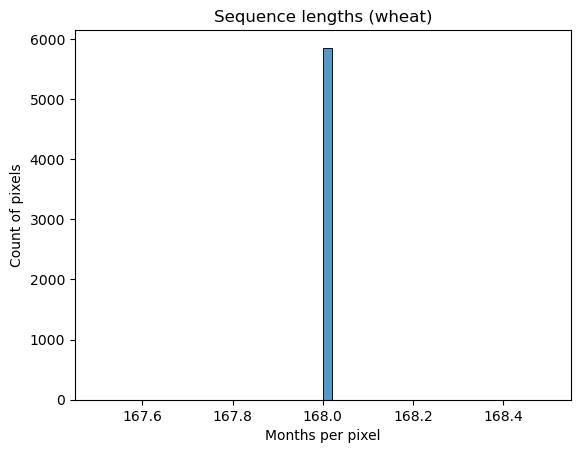


maize:
Min seq len: 168
25%: 168.0
Median: 168.0
75%: 168.0
Max: 168


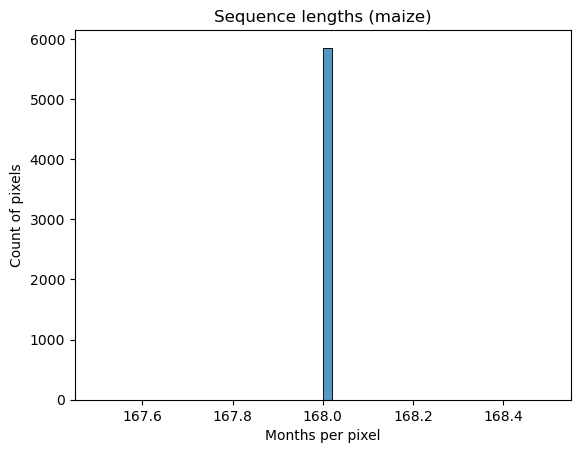

In [5]:
# ---
# ## 4. Sequence lengths per pixel
# ---

def seq_length_stats(df, name):
    lens = df.groupby("pixel_id").size()
    print(f"\n{name}:")
    print("Min seq len:", lens.min())
    print("25%:", lens.quantile(0.25))
    print("Median:", lens.median())
    print("75%:", lens.quantile(0.75))
    print("Max:", lens.max())

    sns.histplot(lens, bins=50)
    plt.title(f"Sequence lengths ({name})")
    plt.xlabel("Months per pixel")
    plt.ylabel("Count of pixels")
    plt.show()

seq_length_stats(df_wheat, "wheat")
seq_length_stats(df_maize, "maize")

Fertilizer cols: ['fert_wheat_n', 'fert_wheat_p2o5', 'fert_wheat_k2o']


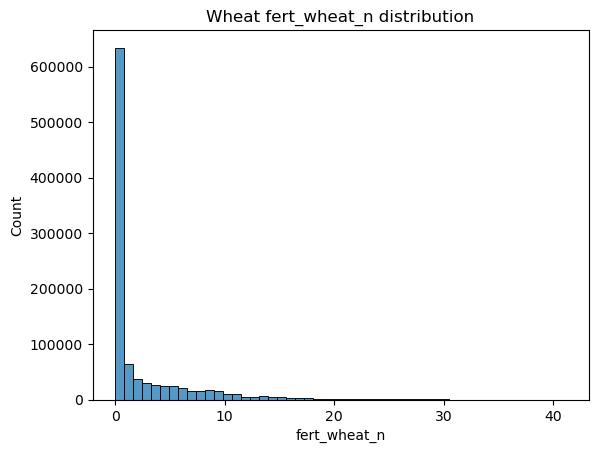

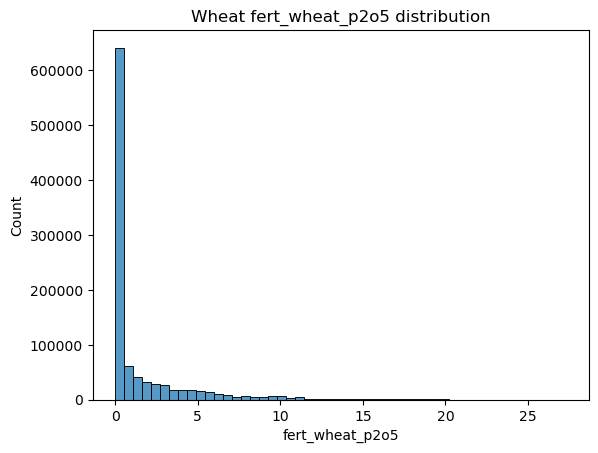

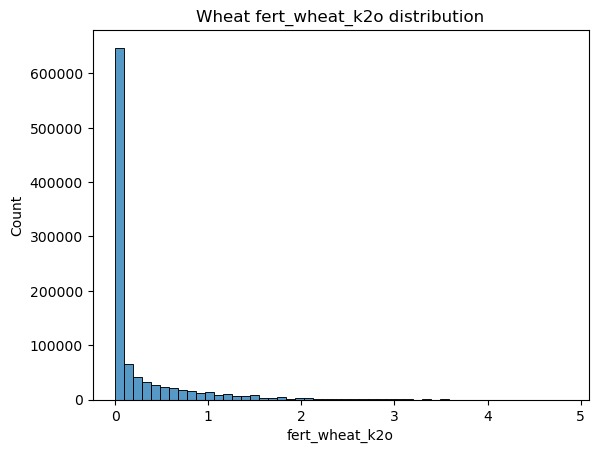

In [6]:
# ---
# ## 5. Distribution of fertilizer features
# ---

fert_cols = [c for c in df_wheat.columns if c.startswith("fert_")]
print("Fertilizer cols:", fert_cols)

for c in fert_cols:
    sns.histplot(df_wheat[c].dropna(), bins=50, kde=False)
    plt.title(f"Wheat {c} distribution")
    plt.show()

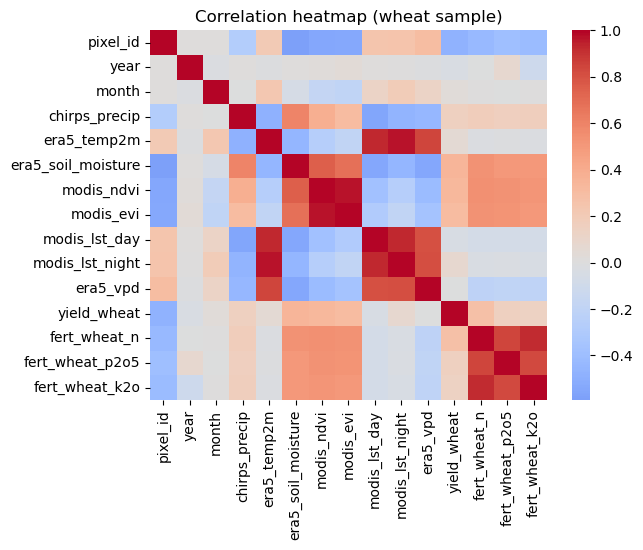

In [7]:
# ---
# ## 6. Correlation heatmap (optional)
# ---

sample = df_wheat.sample(n=min(5000, len(df_wheat)), random_state=0)
sns.heatmap(sample.corr(), cmap="coolwarm", center=0)
plt.title("Correlation heatmap (wheat sample)")
plt.show()

# ---
# ## 7. Decide cleaning
# ---
# Here you can check:
# - Columns with persistent NaNs
# - Whether to drop or interpolate sequences
# - Fertilizer value ranges (look for impossible values)
# - Outlier sequences (very short or too many missing months)

## VIZ